In [413]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score

- Women with ADHD penalized twice as much 
- Try graph neural net and convolutional neural net

In [414]:
def weighted_f1(y_true, y_pred, weight_column):
    # Assign a weight of 2x for Female ADHD cases
    weight = np.ones_like(y_true)
    weight[(y_true == 1) & (weight_column == 1)] = 3  # Apply 2x weight for Female ADHD

    f1 = f1_score(y_true, y_pred, average="weighted", sample_weight=weight)
    return f1

### Load in the training data

In [415]:
# Use read_excel and use participant_id as the index
train_cat = pd.read_excel("../data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_func = pd.read_csv("../data/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
train_quant = pd.read_excel("../data/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_soln = pd.read_excel("../data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

In [416]:
display(train_cat.head(), train_func.head(), train_quant.head(), train_soln.head())

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.222930,0.527903,0.429966,0.060457,0.566489,0.315342,0.508408,-0.078290,0.525692,...,0.224985,0.397448,0.422966,0.184642,0.305549,0.420349,0.016328,0.561864,0.471170,0.365221
1,WHWymJu6zNZi,0.614765,0.577255,0.496127,0.496606,0.404686,0.439724,0.122590,-0.085452,0.120673,...,0.217546,-0.014549,0.000440,-0.096451,0.454501,0.343916,0.167313,0.607656,0.550623,0.503176
2,4PAQp1M6EyAo,-0.116833,0.458408,0.260703,0.639031,0.769337,0.442528,0.637110,0.192010,0.520379,...,0.342487,-0.021141,-0.037836,0.075069,0.412712,0.292708,0.391005,0.461544,0.508912,0.624232
3,obEacy4Of68I,0.199688,0.752714,0.658283,0.575096,0.692867,0.645789,0.522750,0.412188,0.530843,...,0.103562,-0.178313,0.210983,-0.018666,0.436313,0.592982,0.216205,0.341272,0.440313,0.558193
4,s7WzzDcmDOhF,0.227321,0.613268,0.621447,0.562673,0.736709,0.589813,0.266676,0.359668,0.300771,...,-0.164956,0.007064,-0.120904,-0.488095,0.493575,-0.215361,0.210685,0.055850,0.119065,0.108273


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


In [417]:
data_dict = pd.read_excel("../data/Data Dictionary.xlsx")
data_dict

,DataType,Instrument,Field,Description,Type,Labels
0,QUANTITATIVE METADATA,NaN,NaN,NaN,NaN,NaN
1,NaN,Identifier,participant_id,Participant ID,str,NaN
2,Quantitative,Edinburgh Handedness Questionnaire,EHQ_EHQ_Total,Laterality Index (Score),float,-100 = 10th left\n−28 ≤ LI < 48 = middle\n100 ...
3,Quantitative,Ishihara Color Vision Test,ColorVision_CV_Score,Color vision test score,int,NaN
4,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_CP,Corporal Punishment Score,int,NaN
5,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_ID,Inconsistent Discipline Score,int,NaN
6,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_INV,Involvement Score,int,NaN
7,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_OPD,Other Discipline Practices Score (Not factored...,int,NaN
8,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PM,Poor Monitoring/Supervision Score,int,NaN
9,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PP,Positive Parenting Score,int,NaN


## train_cat: One-hot encoding on the categorical values
1. Turn the numbers into their labels using the values provided in the data dictionary.
2. Use pandas to perform one-hot encoding so that the models can interpret the binary values instead of arbitrary numbers.

In [418]:
Basic_Demos_Study_Site = {
    1: "Staten Island",
    2: "MRV",
    3: "Midtown",
    4: "Harlem",
    5: "SI RUMC",
}

PreInt_Demos_Fam_Child_Ethnicity = {
    0: "Not Hispanic or Latino",
    1: "Hispanic or Latino",
    2: "Decline to specify",
    3: "Unknown"
}

PreInt_Demos_Fam_Child_Race = {
  0: "White/Caucasian",
  1: "Black/African American",
  2: "Hispanic",
  3: "Asian",
  4: "Indian",
  5: "Native American Indian",
  6: "American Indian/Alaskan Native",
  7: "Native Hawaiian/Other Pacific Islander",
  8: "Two or more races",
  9: "Other race",
  10: "Unknown",
  11: "Chose not to specify"}

MRI_Track_Scan_Location = {
    1: "Staten Island",
    2: "RUBIC", 
    3: "CBIC",
    4: "CUNY"
}

Barratt_Barratt_P1_Edu = {
    3: "Less than 7th grade",
    6: "Junior high/Middle school (9th grade)",
    9: "Partial high school (10th or 11th grade)",
    12: "High school graduate",
    15: "Partial college (at least one year)",
    18: "College education",
    21: "Graduate degree"
}

Barratt_Barratt_P1_Occ = {
    0: "Homemaker, stay at home parent.",
    5: "Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.",
    10: "Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.",
    15: "Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.",
    20: "Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.",
    25: "Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.",
    30: "Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",
    35: "Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.",
    40: "Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.",
    45: "Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant."
}

Barratt_Barratt_P2_Edu = {
    3: "Less than 7th grade",
    6: "Junior high/Middle school (9th grade)",
    9: "Partial high school (10th or 11th grade)",
    12: "High school graduate",
    15: "Partial college (at least one year)",
    18: "College education",
    21: "Graduate degree"
}

Barratt_Barratt_P2_Occ = {
    0: "Homemaker, stay at home parent.",
    5: "Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.",
    10: "Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.",
    15: "Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.",
    20: "Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.",
    25: "Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.",
    30: "Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",
    35: "Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.",
    40: "Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.",
    45: "Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.",
}



In [419]:
# Apply label replacements using the dictionaries
train_cat["Basic_Demos_Study_Site"] = train_cat["Basic_Demos_Study_Site"].replace(
    Basic_Demos_Study_Site
)
train_cat["PreInt_Demos_Fam_Child_Ethnicity"] = train_cat[
    "PreInt_Demos_Fam_Child_Ethnicity"
].replace(PreInt_Demos_Fam_Child_Ethnicity)
train_cat["PreInt_Demos_Fam_Child_Race"] = train_cat[
    "PreInt_Demos_Fam_Child_Race"
].replace(PreInt_Demos_Fam_Child_Race)
train_cat["MRI_Track_Scan_Location"] = train_cat["MRI_Track_Scan_Location"].replace(
    MRI_Track_Scan_Location
)
train_cat["Barratt_Barratt_P1_Edu"] = train_cat["Barratt_Barratt_P1_Edu"].replace(
    Barratt_Barratt_P1_Edu
)
train_cat["Barratt_Barratt_P1_Occ"] = train_cat["Barratt_Barratt_P1_Occ"].replace(
    Barratt_Barratt_P1_Occ
)
train_cat["Barratt_Barratt_P2_Edu"] = train_cat["Barratt_Barratt_P2_Edu"].replace(
    Barratt_Barratt_P2_Edu
)
train_cat["Barratt_Barratt_P2_Occ"] = train_cat["Barratt_Barratt_P2_Occ"].replace(
    Barratt_Barratt_P2_Occ
)

In [420]:
# One-hot encode all columns except 'participant_id' and 'Basic_Demos_Enroll_Year'
train_cat_encoded = pd.get_dummies(
    train_cat,
    columns=[
        "Basic_Demos_Study_Site",
        "PreInt_Demos_Fam_Child_Ethnicity",
        "PreInt_Demos_Fam_Child_Race",
        "MRI_Track_Scan_Location",
        "Barratt_Barratt_P1_Edu",
        "Barratt_Barratt_P1_Occ",
        "Barratt_Barratt_P2_Edu",
        "Barratt_Barratt_P2_Occ",
    ],
    dummy_na=True,  # Optional: adds a column for NaNs if present
    drop_first=False,  # Set to True if you want to drop the first category to avoid multicollinearity
)

# Check the result
train_cat_encoded.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site_Harlem,Basic_Demos_Study_Site_MRV,Basic_Demos_Study_Site_Midtown,Basic_Demos_Study_Site_Staten Island,Basic_Demos_Study_Site_nan,PreInt_Demos_Fam_Child_Ethnicity_Decline to specify,PreInt_Demos_Fam_Child_Ethnicity_Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Not Hispanic or Latino,...,"Barratt_Barratt_P2_Occ_Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.","Barratt_Barratt_P2_Occ_Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.","Barratt_Barratt_P2_Occ_Homemaker, stay at home parent.","Barratt_Barratt_P2_Occ_Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.","Barratt_Barratt_P2_Occ_Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.","Barratt_Barratt_P2_Occ_Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.","Barratt_Barratt_P2_Occ_Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.","Barratt_Barratt_P2_Occ_Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.","Barratt_Barratt_P2_Occ_Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",Barratt_Barratt_P2_Occ_nan
0,00aIpNTbG5uh,2019,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,00fV0OyyoLfw,2017,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,04X1eiS79T4B,2017,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,05ocQutkURd6,2018,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,06YUNBA9ZRLq,2018,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


## train_func: reduce the dimensionality of the functional MRI connectome matrix

Original shape: (1213, 19900)
Transformed shape: (1213, 374)


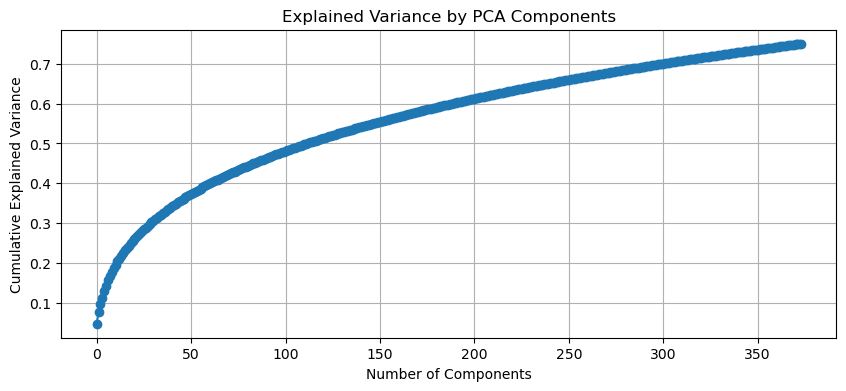

In [475]:
# Separate the features (connectome matrix) from the participant IDs
X = train_func.drop(columns=["participant_id"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Want to capture 80% of the variance
pca = PCA(n_components=0.75)
X_pca = pca.fit_transform(X_scaled)

# Shape of the transformed data
print("Original shape:", X_scaled.shape)
print("Transformed shape:", X_pca.shape)

# Explained variance
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

In [476]:
train_func_pca = pd.DataFrame(
    X_pca,
    index=train_func["participant_id"],
    columns=[f"fmri_pca_{i+1}" for i in range(X_pca.shape[1])],
)
train_func_pca.head()

,fmri_pca_1,fmri_pca_2,fmri_pca_3,fmri_pca_4,fmri_pca_5,fmri_pca_6,fmri_pca_7,fmri_pca_8,fmri_pca_9,fmri_pca_10,...,fmri_pca_365,fmri_pca_366,fmri_pca_367,fmri_pca_368,fmri_pca_369,fmri_pca_370,fmri_pca_371,fmri_pca_372,fmri_pca_373,fmri_pca_374
participant_id,,,,,,,,,,,,,,,,,,,,,
70z8Q2xdTXM3,35.753597,0.090543,-20.350098,-19.088315,-30.805000,2.306746,0.012355,-16.080110,-6.713655,7.132238,...,2.728630,3.624376,7.328032,0.519485,-4.555403,2.053052,2.680633,-2.253445,-4.179281,-7.029821
WHWymJu6zNZi,28.459455,-18.887916,10.232790,-1.115161,-7.235638,-14.893705,5.991655,-3.274425,-18.623446,-12.154646,...,-7.260684,3.073914,-4.605969,-3.054074,3.308322,6.665138,-1.074939,2.469420,0.466371,-9.790032
4PAQp1M6EyAo,0.798687,4.718468,10.989505,17.687384,10.643912,31.792714,-9.804087,16.585635,-15.010728,-8.778202,...,-8.038183,3.530339,2.041309,4.689802,-3.786987,1.600690,-0.005642,1.872627,3.153888,7.690318
obEacy4Of68I,-45.767171,-11.453186,4.095472,-12.695696,-20.976370,22.331782,4.630708,-4.709863,0.145218,10.252135,...,4.634713,-0.796169,-0.771741,4.738684,0.529358,0.272077,0.215169,-3.410990,0.096420,-0.818768
s7WzzDcmDOhF,3.746646,-8.847485,10.058838,2.305610,-3.341812,14.484016,28.106098,5.519340,-6.920033,4.655665,...,-1.953884,-2.365631,-0.135550,4.950007,0.150664,-5.008666,-4.887243,-1.141756,-9.435371,-2.796549


In [477]:
# Deal with NaN values
train_quant = train_quant.fillna(
    train_quant.drop("participant_id", axis=1).mean()
)
train_quant.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,11.245678
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


### Make one input matrix X by merging on participant_id
Currently, the dataframes are:
- train_cat_encoded (one-hot encoded so all binary)
- train_func_pca (reduced to 374 PCs)
- train_quant (dealt with NaN values)
- they all have 1213 rows, so the merging shouldn't lose any data
- they all have the participant_id column, which will uniquely merge each row

In [478]:
cat_func_merge = pd.merge(train_cat_encoded, train_func_pca, how='outer', on="participant_id")
X_with_id = pd.merge(cat_func_merge, train_quant, how="outer", on="participant_id")
X = X_with_id.drop("participant_id", axis=1)
# Turn boolean columns into integers (0/1)
X = X.astype({col: int for col in X.select_dtypes("bool").columns})
X.head()

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site_Harlem,Basic_Demos_Study_Site_MRV,Basic_Demos_Study_Site_Midtown,Basic_Demos_Study_Site_Staten Island,Basic_Demos_Study_Site_nan,PreInt_Demos_Fam_Child_Ethnicity_Decline to specify,PreInt_Demos_Fam_Child_Ethnicity_Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Not Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Unknown,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,2019,1,0,0,0,0,0,1,0,0,...,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,2017,0,0,0,1,0,0,0,1,0,...,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,11.245678
2,2017,0,0,0,1,0,0,1,0,0,...,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,2018,0,0,0,1,0,0,0,0,1,...,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,2018,0,0,0,1,0,0,0,1,0,...,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [479]:
y_sex = train_soln["Sex_F"]  
y_adhd = train_soln["ADHD_Outcome"] 

In [480]:
train_soln.head()

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


In [481]:
# Split into train and validation using y_sex
X_train, X_val, y_train_sex, y_val_sex, y_train_adhd, y_val_adhd = train_test_split(
    X, y_sex, y_adhd, test_size=0.2, random_state=42
)

In [482]:
# Scale inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [483]:
# Step 1: Convert the data to DMatrix (XGBoost format)
dtrain_sex = xgb.DMatrix(X_train_scaled, label=y_train_sex)
dval_sex = xgb.DMatrix(X_val_scaled, label=y_val_sex)

dtrain_adhd = xgb.DMatrix(X_train, label=y_train_adhd)
dval_adhd = xgb.DMatrix(X_val, label=y_val_adhd)

In [484]:
# Step 2: Set up parameters
params_sex = {
    "objective": "binary:logistic",  # Binary classification
    "eval_metric": ["logloss", "auc", "aucpr"],  # Log loss evaluation metric
    "scale_pos_weight": sum(y_train_sex == 0)
    / sum(y_train_sex == 1),  # Handling class imbalance
    "max_depth": 5,  # Maximum depth of the trees
    "eta": 0.05,  # Learning rate
    "subsample": 0.8,  # Subsample ratio of the training data
    "colsample_bytree": 0.8,  # Subsample ratio of features
    "nthread": 4,  # Number of threads (adjust based on your system)
}

# Step 2: Set up parameters
params_adhd = {
    "objective": "binary:logistic",  # Binary classification
    "eval_metric": ["logloss", "auc", "aucpr"],  # Log loss evaluation metric
    "scale_pos_weight": sum(y_train_adhd == 0)
    / sum(y_train_adhd == 1),  # Handling class imbalance
    "max_depth": 5,  # Maximum depth of the trees
    "eta": 0.05,  # Learning rate
    "subsample": 0.8,  # Subsample ratio of the training data
    "colsample_bytree": 0.8,  # Subsample ratio of features
    "nthread": 4,  # Number of threads (adjust based on your system)
}

In [485]:
# Fit sex model
sex_model = xgb.train(
    params_sex,
    dtrain_sex,
    num_boost_round=100,  # Number of boosting rounds
    evals=[(dtrain_sex, "train"), (dval_sex, "validation")],
    early_stopping_rounds=20,  # Stop if validation error doesn't improve
)

# Fit ADHD model
adhd_model = xgb.train(
    params_adhd,
    dtrain_adhd,
    num_boost_round=100,
    evals=[(dtrain_adhd, "train"), (dval_adhd, "validation")],
    early_stopping_rounds=20,
)

[0]	train-logloss:0.68070	train-auc:0.76809	train-aucpr:0.62787	validation-logloss:0.68878	validation-auc:0.58285	validation-aucpr:0.36096
[1]	train-logloss:0.66739	train-auc:0.86026	train-aucpr:0.77959	validation-logloss:0.68475	validation-auc:0.57988	validation-aucpr:0.37253
[2]	train-logloss:0.65680	train-auc:0.90848	train-aucpr:0.84948	validation-logloss:0.68399	validation-auc:0.55515	validation-aucpr:0.37363
[3]	train-logloss:0.64744	train-auc:0.93387	train-aucpr:0.89709	validation-logloss:0.68196	validation-auc:0.56758	validation-aucpr:0.40754
[4]	train-logloss:0.63241	train-auc:0.95096	train-aucpr:0.92323	validation-logloss:0.68154	validation-auc:0.54914	validation-aucpr:0.37181
[5]	train-logloss:0.62082	train-auc:0.96771	train-aucpr:0.95144	validation-logloss:0.67830	validation-auc:0.57107	validation-aucpr:0.42189
[6]	train-logloss:0.60962	train-auc:0.97640	train-aucpr:0.96471	validation-logloss:0.67825	validation-auc:0.53923	validation-aucpr:0.37364
[7]	train-logloss:0.59934	t

## Model: XGBoost model (extreme gradient boosting)

### Try to optimize parameters more

In [486]:
sex_probs = sex_model.predict(dval_sex)  # Probabilities
adhd_probs = adhd_model.predict(dval_adhd)

In [559]:
def penalized_combination_f1(y_true_sex, y_true_adhd, y_pred_sex, y_pred_adhd):
    # Create a weight array for ADHD outcome: double weight if female ADHD case
    weights = 1 + ((y_true_sex == 1) & (y_true_adhd == 1)).astype(int)

    # E.g. if patient is actually a female with adhd, this gets a weight of 2

    # Custom F1 score for ADHD with sample weights
    f1_adhd = f1_score(y_true_adhd, y_pred_adhd, sample_weight=weights)

    # Custom F1 core for sex with sample weights
    f1_sex = f1_score(y_true_sex, y_pred_sex, sample_weight=weights)

    return 0.5 * (f1_adhd + f1_sex)

weights: 382    2
787    1
43     1
155    1
493    2
      ..
59     1
837    1
63     1
722    1
644    1
Length: 243, dtype: int64, f1 adhd: 0.8727984344422701
weights: 382    2
787    1
43     1
155    1
493    2
      ..
59     1
837    1
63     1
722    1
644    1
Length: 243, dtype: int64, f1 adhd: 0.8727984344422701
weights: 382    2
787    1
43     1
155    1
493    2
      ..
59     1
837    1
63     1
722    1
644    1
Length: 243, dtype: int64, f1 adhd: 0.8727984344422701
weights: 382    2
787    1
43     1
155    1
493    2
      ..
59     1
837    1
63     1
722    1
644    1
Length: 243, dtype: int64, f1 adhd: 0.8727984344422701
weights: 382    2
787    1
43     1
155    1
493    2
      ..
59     1
837    1
63     1
722    1
644    1
Length: 243, dtype: int64, f1 adhd: 0.8727984344422701
weights: 382    2
787    1
43     1
155    1
493    2
      ..
59     1
837    1
63     1
722    1
644    1
Length: 243, dtype: int64, f1 adhd: 0.8727984344422701
weights: 382    2
787 

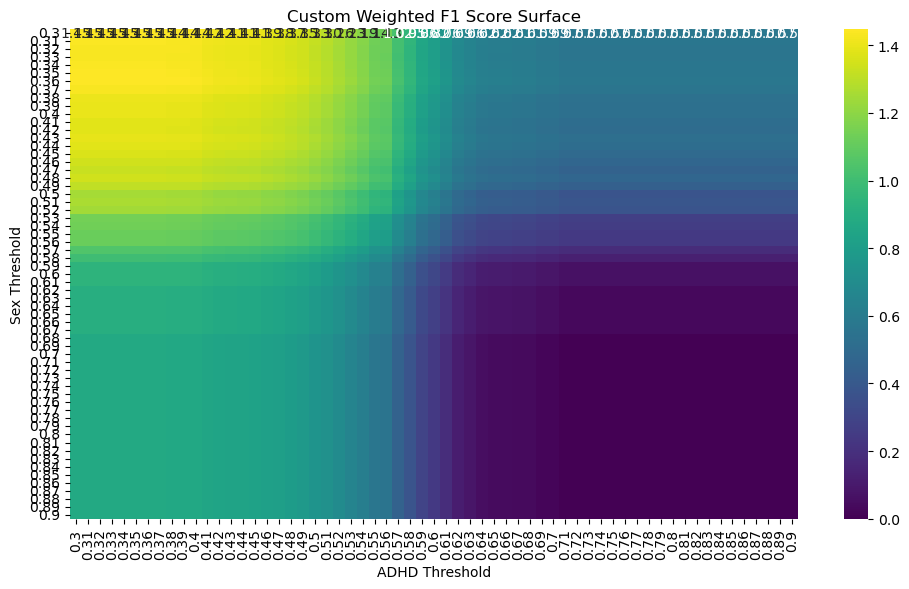

In [558]:
thresholds_sex = np.arange(0.3, 0.9, 0.01)
thresholds_adhd = np.arange(0.3, 0.9, 0.01)

f1_scores = []

# Make predictions based on our two trained models above
y_pred_prob_sex = sex_model.predict(dval_sex)
y_pred_prob_adhd = adhd_model.predict(dval_adhd)

for thresh_s in thresholds_sex:
    for thresh_a in thresholds_adhd:
        pred_sex = (y_pred_prob_sex > thresh_s).astype(int)
        pred_adhd = (y_pred_prob_adhd > thresh_a).astype(int)

        f1 = penalized_combination_f1(y_val_sex, y_val_adhd, pred_sex, pred_adhd)
        f1_scores.append(f1)


# Reshape to 2D (sex_thresholds x adhd_thresholds)
f1_array = np.array(f1_scores).reshape(len(thresholds_sex), len(thresholds_adhd))

# Get indices of max F1 score
best_idx = np.unravel_index(np.argmax(f1_array), f1_array.shape)
best_sex_idx, best_adhd_idx = best_idx

# Get corresponding thresholds
best_thresh_sex = thresholds_sex[best_sex_idx]
best_thresh_adhd = thresholds_adhd[best_adhd_idx]
best_f1 = f1_array[best_sex_idx, best_adhd_idx]

print(f"Best threshold sex (custom weighted F1): {best_thresh_sex:.2f}")
print(f"Best threshold ADHD (custom weighted F1): {best_thresh_adhd:.2f}")
print(f"Best Weighted F1 Score: {best_f1:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(
    f1_array,
    xticklabels=np.round(thresholds_adhd, 2),
    yticklabels=np.round(thresholds_sex, 2),
    cmap="viridis",
    annot=True,
    fmt=".2f",
)
plt.xlabel("ADHD Threshold")
plt.ylabel("Sex Threshold")
plt.title("Custom Weighted F1 Score Surface")
plt.tight_layout()
plt.show()

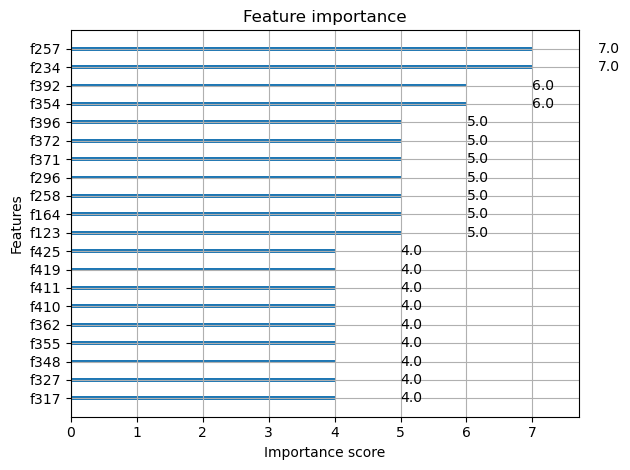

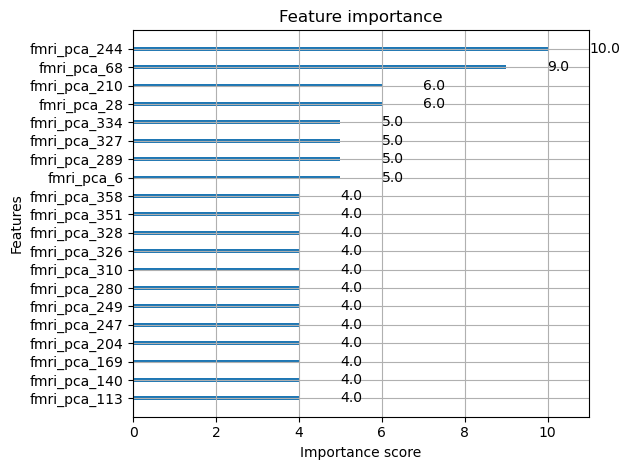

In [546]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot importance for sex model
ax = xgb.plot_importance(
    sex_model, max_num_features=20
)  # adjust max_num_features if needed
for label in ax.get_yticklabels():
    label.set_rotation(
        0
    )  # 0 degrees for horizontal

plt.tight_layout()
plt.show()

# Plot importance for ADHD model
ax = xgb.plot_importance(adhd_model, max_num_features=20)
for label in ax.get_yticklabels():
    label.set_rotation(0)

plt.tight_layout()
plt.show()

### Get our submission file - XGBoost model
#### Do the same pre-processing to the TEST data

In [547]:
# Load the testing data
test_cat = pd.read_excel("../data/TEST/TEST_CATEGORICAL.xlsx")
test_func = pd.read_csv("../data/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
test_quant = pd.read_excel("../data/TEST/TEST_QUANTITATIVE_METADATA.xlsx")

In [548]:
# Apply label replacements for the test data (same as for training data)
test_cat["Basic_Demos_Study_Site"] = test_cat["Basic_Demos_Study_Site"].replace(
    Basic_Demos_Study_Site
)
test_cat["PreInt_Demos_Fam_Child_Ethnicity"] = test_cat[
    "PreInt_Demos_Fam_Child_Ethnicity"
].replace(PreInt_Demos_Fam_Child_Ethnicity)
test_cat["PreInt_Demos_Fam_Child_Race"] = test_cat[
    "PreInt_Demos_Fam_Child_Race"
].replace(PreInt_Demos_Fam_Child_Race)
test_cat["MRI_Track_Scan_Location"] = test_cat["MRI_Track_Scan_Location"].replace(
    MRI_Track_Scan_Location
)
test_cat["Barratt_Barratt_P1_Edu"] = test_cat["Barratt_Barratt_P1_Edu"].replace(
    Barratt_Barratt_P1_Edu
)
test_cat["Barratt_Barratt_P1_Occ"] = test_cat["Barratt_Barratt_P1_Occ"].replace(
    Barratt_Barratt_P1_Occ
)
test_cat["Barratt_Barratt_P2_Edu"] = test_cat["Barratt_Barratt_P2_Edu"].replace(
    Barratt_Barratt_P2_Edu
)
test_cat["Barratt_Barratt_P2_Occ"] = test_cat["Barratt_Barratt_P2_Occ"].replace(
    Barratt_Barratt_P2_Occ
)

# One-hot encode the categorical columns for test data
test_cat_encoded = pd.get_dummies(
    test_cat,
    columns=[
        "Basic_Demos_Study_Site",
        "PreInt_Demos_Fam_Child_Ethnicity",
        "PreInt_Demos_Fam_Child_Race",
        "MRI_Track_Scan_Location",
        "Barratt_Barratt_P1_Edu",
        "Barratt_Barratt_P1_Occ",
        "Barratt_Barratt_P2_Edu",
        "Barratt_Barratt_P2_Occ",
    ],
    dummy_na=True,
    drop_first=False,
)

In [549]:
# Ensure 'participant_id' is kept for merging later
test_participant_ids = test_func["participant_id"]
test_func = test_func.drop(columns=["participant_id"])

In [550]:
scaler = StandardScaler()

# Fit the scaler on the training data (train_func) first
scaler.fit(train_func.drop(columns=["participant_id"]))
X_test_scaled = scaler.transform(test_func)

In [551]:
# PCA transformation (fit on training data, then apply to test data)
# Make sure to initialize the PCA model before using it for transformation
pca = PCA(n_components=0.75)
pca.fit(X_scaled)

# Fit the PCA on the training data (train_func_scaled) and transform the test data
X_test_pca = pca.transform(X_test_scaled)

# Convert PCA data to DataFrame with participant_id as the index
test_func_pca = pd.DataFrame(
    X_test_pca,
    index=test_participant_ids,  # Use the original participant_id from test_func
    columns=[f"fmri_pca_{i+1}" for i in range(X_test_pca.shape[1])],
)

In [552]:
# Handle missing values in quantitative data (fill NaNs with the column means)
test_quant = test_quant.fillna(test_quant.drop("participant_id", axis=1).mean())

In [553]:
# Merge the encoded categorical, PCA features, and quantitative data for the test set
test_data_merged = pd.merge(
    test_cat_encoded, test_func_pca, how="outer", on="participant_id"
)
X_test = pd.merge(test_data_merged, test_quant, how="outer", on="participant_id")
X_test_has_ids = X_test.drop("participant_id", axis=1)
X_test = X_test_has_ids.astype({col: int for col in X_test.select_dtypes("bool").columns})

In [554]:
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

In [555]:
best_thresh_adhd, best_thresh_sex

(0.3, 0.36000000000000004)

In [556]:
# Evaluate model for sex classification

dtest = xgb.DMatrix(X_test)

y_pred_prob_test_sex = sex_model.predict(dtest)  # Probabilities for sex classification
y_pred_prob_test_adhd = adhd_model.predict(dtest)  # Probabilities for adhd classification

y_pred_test_sex = (y_pred_prob_test_sex > best_thresh_sex).astype(int)    # Binary predictions for sex
y_pred_test_adhd = (y_pred_prob_test_adhd > best_thresh_adhd).astype(int)  # Binary predictions for ADHD

# Create a DataFrame with the required columns
submission_df = pd.DataFrame(
    {
        "ADHD_Outcome": y_pred_test_adhd,
        "Sex_F": y_pred_test_sex,
    },
    index=test_participant_ids,
)

# Step 3: Save the predictions to a CSV file
submission_df.to_csv("submissionXGB.csv", index=True)

# Display the first few rows of the submission file
print(submission_df.head(30))

                ADHD_Outcome  Sex_F
participant_id                     
Cfwaf5FX7jWK               1      1
vhGrzmvA3Hjq               1      1
ULliyEXjy4OV               1      1
LZfeAb1xMtql               1      0
EnFOUv0YK1RG               1      1
3VbkvJ22j9Fu               1      0
PRKZcnOgqcuk               1      1
DuVUuyMZi5qV               1      1
uM4etVLZrgMg               1      1
BpzyExrET5ta               1      1
sAqeb6F4lz97               1      1
u7XOOvHirIx7               1      1
aEPm4bEQvbYi               1      1
Fj9A5PWsIWKT               1      0
19mb5yGJigtw               1      1
v1nMpCoLGU0V               1      1
hRPuz4zpsEbw               1      1
mT8A6xa1O4Ro               1      1
4QBTjDoVpVt6               1      1
0X2H4LroxZcw               1      1
9CH7UxXuznUa               1      1
nU73zzjTnr4A               1      1
uEZHGukIUQ0k               1      0
jCzQwkpfgZyQ               1      1
Ljvrs76QJuI5               1      1
IbF3zW0Wbx4Q               1